# Imperfect tests and respondent-driven sampling

For now, we consider the network dependence induced by the RDS with no
associated model. Therefore, we treat it as a random effect for
each individual. Conditionally autoregressive (CAR) models in the
Gaussian case are used. Let $[\tilde{Q}]_{ij} = \tilde{q}_{ij}$ be a fixed matrix which measures the distance between $i$
and $j$, and $\tilde{q}_{i+} = \sum_{j} \tilde{q}_{ij}$. In general, we use

$$
\tilde{q}_{ij} = \begin{cases}
  1, &\text{if } i \text{ recruited } j \text{ or the contrary} \\
  0, &\text{otherwise.} 
\end{cases}
$$

Next we define the scaled adjacency matrix $Q = D^{-1}\tilde{Q}$, such that $D$
is a diagonal matrix with $D_{ii} = \tilde{q}_{i+}$. Finally let $|\rho| < 1$ be a
parameter to controls the dependence between neighbors. Hence, we specify the
model as follows:

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta + \omega_i,  \\
    \omega_i|\{\omega_j\}_{j\neq i}, \tau &\sim \operatorname{Normal}\left(\rho\sum_j q_{ij}\omega_j, \tau^{-1}/\tilde{q}_{i+}\right) \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\  
    \tau &\sim \operatorname{Gamma}(a^{\tau}, b^{\tau}).
  \end{aligned}  
\end{equation}

By Brook's Lemma {cite:t}`brook1964distinction`, the joint distribution of
$\omega$ can be specified as 

$$
\omega \sim \operatorname{Normal}\left(0, \left[\tau (D - \rho \tilde{Q})\right]^{-1}\right).
$$

In [23]:
import numpy as np
import pystan as ps
import stan_utility
from scipy.special import logit, expit
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [3]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

Below we can see the necessary information to the stan code. 

In [4]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int T[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
    real<lower = 0> alpha_tau; 
    real<lower = 0> beta_tau;
    
    matrix[n_samples, n_samples] precision; 
    real<lower = 0, upper = 1> rho; 
}
transformed data{
  vector[n_samples] zeros;
  zeros = rep_vector(0, n_samples);
}


The parameters and transformed parameters of the model. 

In [5]:
print(structure[2] + '}' + structure[3] + '}' + structure[4] + '}') 


parameters {
    vector[n_predictors] effects; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
    
    vector[n_samples] omega; 
    real<lower = 0> tau; 
}
transformed parameters {
    vector[n_samples] theta;
    vector[n_samples] p; 
    
    for (i in 1:n_samples) {
        theta[i] = inv_logit(logit(prev) + x[i] * effects + omega[i]);
        p[i] = sens*theta[i] + (1 - spec)*(1 - theta[i]);
    }
}


The model

In [6]:
print(structure[5] + '}' + structure[6] + '}') 


model {
    tau ~ gamma(alpha_tau, beta_tau); 
    omega ~ multi_normal_prec(zeros, tau * precision);

    effects ~ multi_normal(mu, Sigma);
    prev ~ beta(alpha_p, beta_p);
    
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);

    for (i in 1:n_samples) {
       T[i] ~ bernoulli(p[i]);
    }
}


## Toy example

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. First we get the
data using the class `GenerateData()`. 

In [7]:
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 1000, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                     n_seeds = 10, sample_size = 150, probs = [1/3,1/6,1/6,1/3])

rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))

A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()

n_samples = rds_sample.number_of_nodes()

D = np.diag(A.sum(axis = 1))

Note that we actually only need the adjacency matrix. In the following, we
will use to aggregate that to the entire data. 

In [8]:
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = 200)

# Normalization
x_rds = x[:n_samples]
x_rds = (x_rds - x_rds.mean(axis=0))/x_rds.std(axis = 0, ddof = 1)

In [9]:
# Parameters to generate fake data
tau = 1 
spec = 0.85
sens = 0.8
beta = np.array([0.1, 2.5, -1.0, 1.2, -0.3]).reshape(-1,1)
prevalence = 0.1
rho = 0.5

# Generated quantities
omega = np.random.multivariate_normal(mean = np.zeros(n_samples), cov = tau*np.linalg.inv(D - rho*A))

theta = expit(logit(prevalence) + (x_rds@beta) + omega.reshape(-1,1))
p = sens*theta + (1 - spec)*(1 - theta)
T = ro.binomial(n = 1, p = p)

# Hyperparameters of the model. 
Sigma   = np.eye(5)
mu      = np.zeros(5)
alpha_p = 1
beta_p  = 3
alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x_rds,
    "precision"    : D - rho*A,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

How the numerical part of the problem enters the picture

```{python}
%%time
fit_rds_imperfect_eff = sm.sampling(data=data, iter=4000)
summary = az.summary(fit_rds_imperfect_eff)
```

This implementation was expected to not converge and take a long time, because
the implementation of CAR is very inefficient.  Because of that, we use [this
implementation](https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html).

## Efficient implementation of CAR

In [33]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_23285064baabc0b1b76942b1e8717f1f NOW.


We use the data generated before. 

In [35]:
Sigma      = np.eye(5)
mu         = np.zeros(5)
alpha_p    = 1
beta_p     = 3
alpha_s    = 4
beta_s     = 1
alpha_e    = 4
beta_e     = 1
lambda_tau = np.log(10)

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x_rds,
    "adj_matrix"   : A,
    "adj_pairs"    : int(A.sum()/2),
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
    "lambda_tau"   : lambda_tau,  
    "rho"          : 0.0, 
}

### Distribution for the precision parameter

Commonly used priors with finite mean for $\tau$ will overfit (XXX: Add
reference). Following (XXX: add ref), we use a Penalized Complexity prior for
$\tau$ with the following density:

$$
\pi(\tau) = \frac{\lambda}{2}\tau^{-3/2}\exp(-\lambda\tau^{-1/2}),
$$

which is a type-2 Gumbel precision. 

In [36]:
structure = sm.model_code.split('}')
print(structure[4] + '}') 


  real gumbel_type2_lpdf(real tau, real lambda){
    return log(lambda) - 3/2 * log(tau) - lambda*tau^(-1/2) - log(2); 
  }


In [37]:
%%time
fit_rds_imperfect_eff = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_rds_imperfect_eff)

CPU times: user 22 s, sys: 208 ms, total: 22.2 s
Wall time: 1min 14s


In [38]:
some_parameters = summary.loc[['prev', 'spec','sens', 'effects[0]','effects[1]','effects[2]','effects[3]','effects[4]', 'tau']]
some_parameters.insert(0, 'real_values', (prevalence, spec, sens, *tuple(beta.flatten()), tau))
some_parameters

,real_values,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prev,0.10,0.168,0.063,0.050,0.277,0.002,0.001,1321.0,1321.0,1173.0,1410.0,1.01
spec,0.85,0.953,0.033,0.895,1.000,0.001,0.001,1442.0,1413.0,1084.0,561.0,1.00
sens,0.80,0.884,0.093,0.714,1.000,0.003,0.002,1213.0,1141.0,913.0,1401.0,1.00
effects[0],0.10,-0.288,0.277,-0.819,0.219,0.006,0.005,1941.0,1634.0,1938.0,1882.0,1.00
effects[1],2.50,1.741,0.425,1.006,2.572,0.013,0.009,1138.0,1138.0,1130.0,3052.0,1.01
effects[2],-1.00,-0.791,0.291,-1.331,-0.237,0.007,0.005,1898.0,1864.0,1905.0,2915.0,1.00
effects[3],1.20,0.856,0.304,0.315,1.442,0.008,0.006,1503.0,1469.0,1513.0,3191.0,1.00
effects[4],-0.30,-0.432,0.304,-1.036,0.095,0.008,0.006,1468.0,1424.0,1491.0,1657.0,1.00
tau,1.00,107.954,244.105,0.120,447.764,85.662,62.892,8.0,8.0,8.0,13.0,1.50


In [39]:
stan_utility.check_all_diagnostics(fit_rds_imperfect_eff)

n_eff / iter for parameter lp__ is 0.0008916849402785305!
  n_eff / iter below 0.001 indicates that the effective sample size has likely been overestimated
Rhat for parameter tau is 1.5019198539472796!
Rhat for parameter lp__ is 1.483652292899499!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 10000 iterations ended with a divergence (0.0%)
49 of 10000 iterations saturated the maximum tree depth of 10 (0.49%)
  Run again with max_treedepth set to a larger value to avoid saturation
Chain 0: E-BFMI = 0.006159001543060567
Chain 1: E-BFMI = 0.01299403541481828
Chain 2: E-BFMI = 0.0050968085321694105
Chain 3: E-BFMI = 0.008532059667839017
  E-BFMI below 0.2 indicates you may need to reparameterize your model


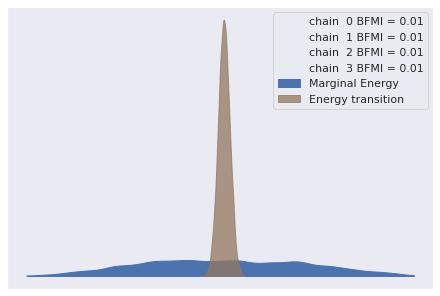

In [40]:
az.plot_energy(fit_rds_imperfect_eff)
plt.show()

In [41]:
info = fit_rds_imperfect_eff.to_dataframe()

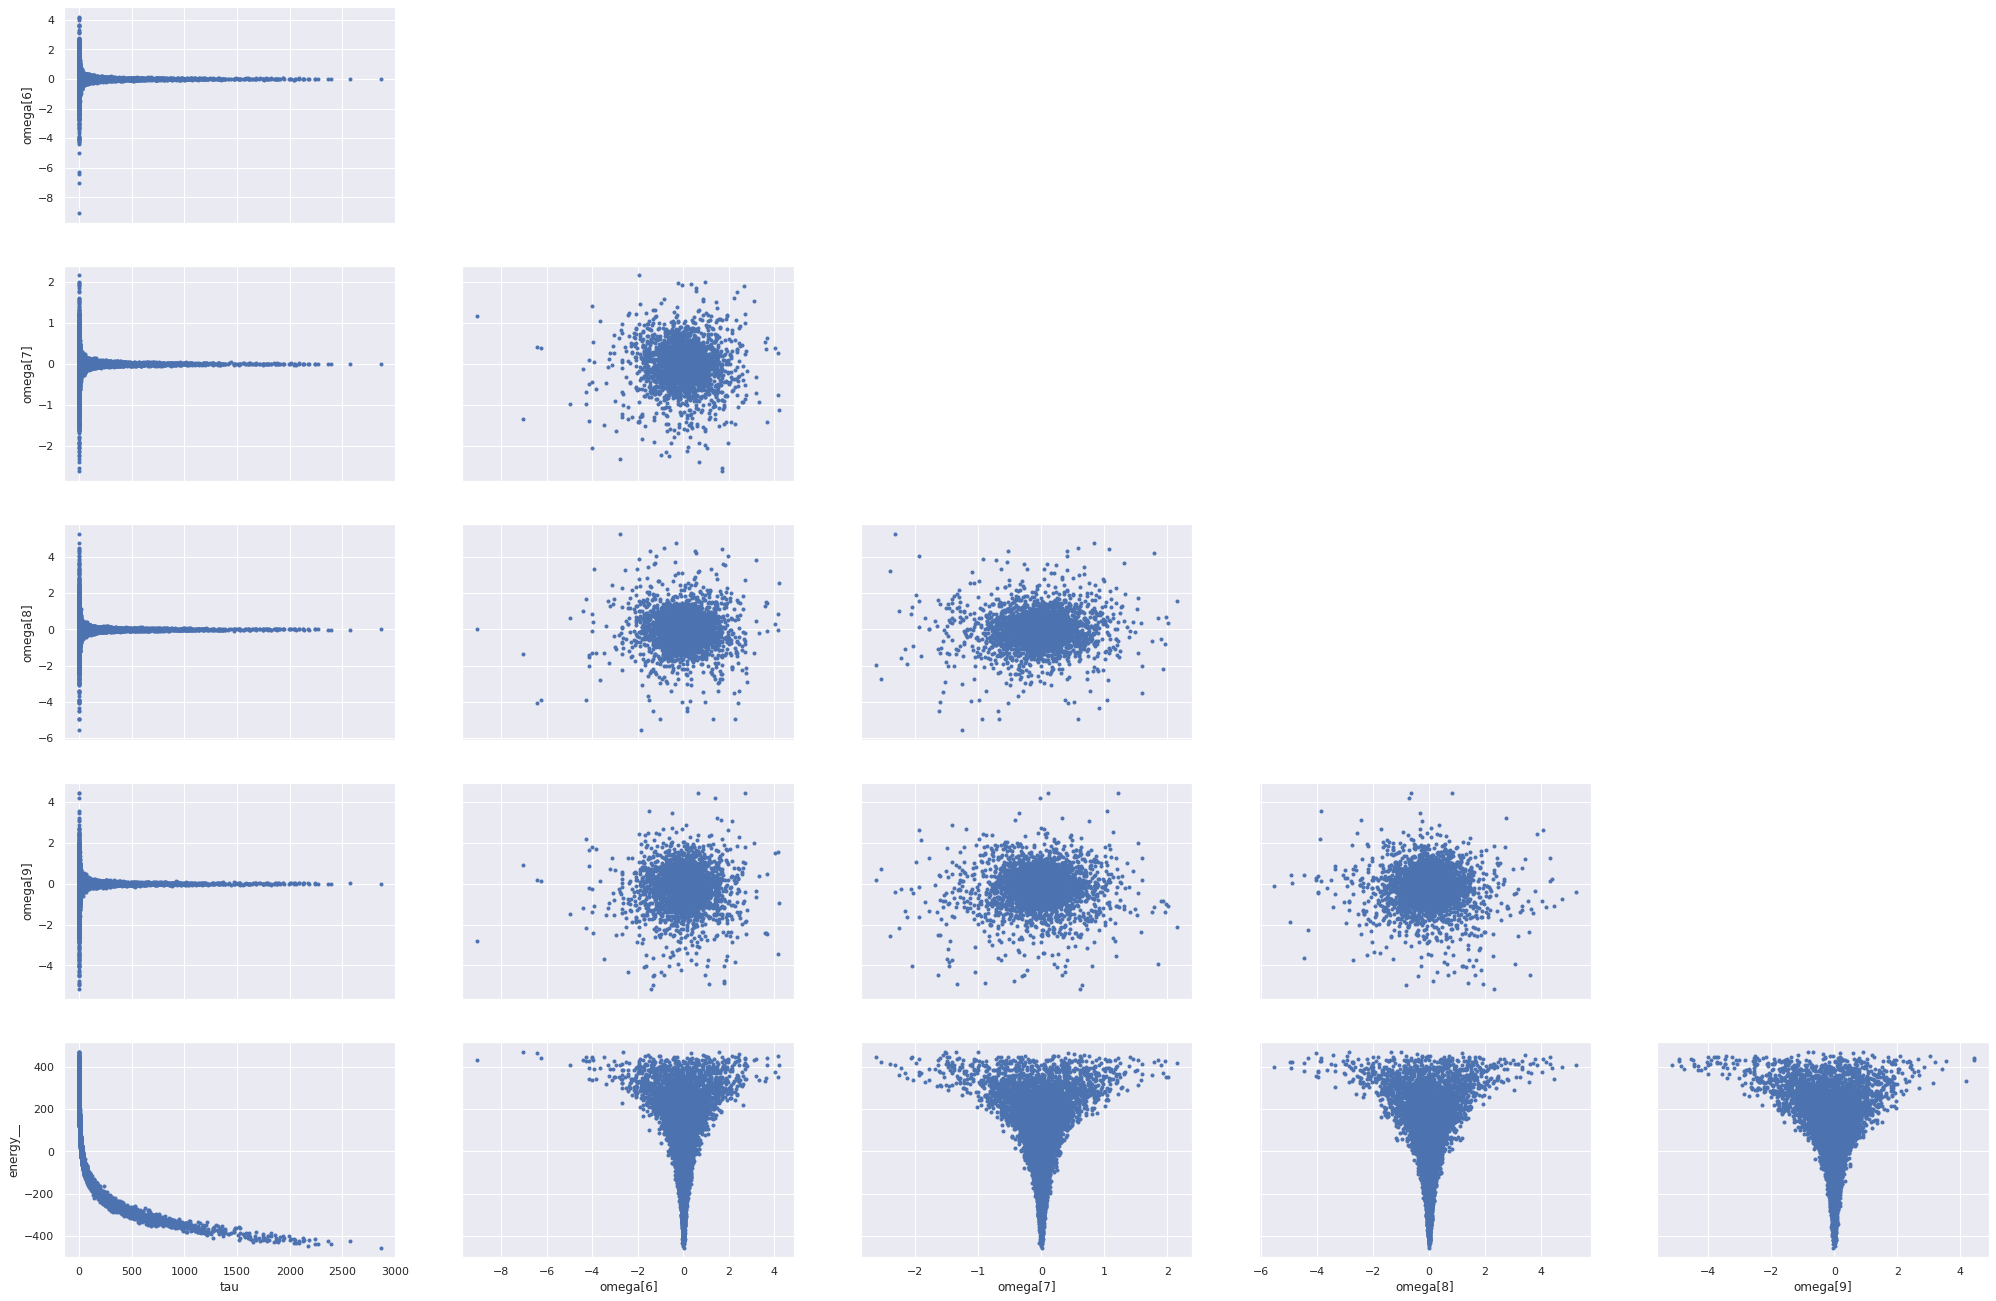

In [42]:
selected_vars = ['tau', 'omega[6]', 'omega[7]', 'omega[8]', 'omega[9]', 'energy__']
samples = {var: info[var] for var in selected_vars}

az.plot_pair(samples)

plt.show()

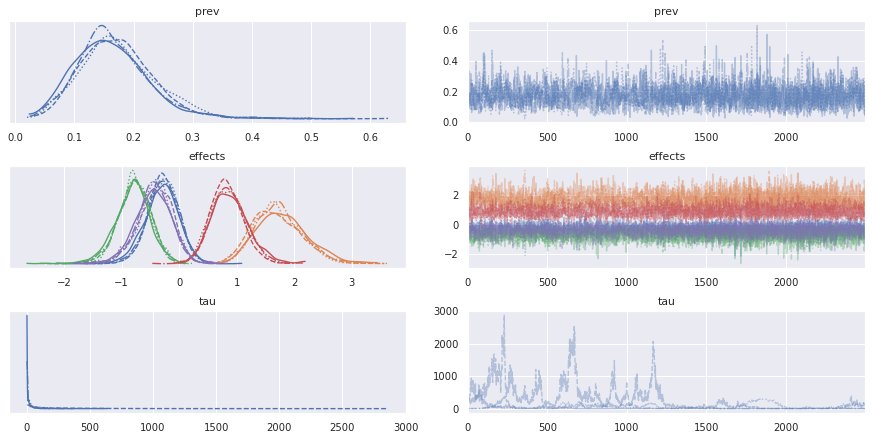

In [44]:
az.plot_trace(fit_rds_imperfect_eff, var_names=('prev', 'effects', 'tau'))
plt.show()